In [1]:
import os
import pickle
from glob import glob
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from upsetplot import generate_counts, plot, UpSet
from protlearn.features import aaindex1
from protlearn.preprocessing import remove_unnatural
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, average_precision_score

def fasta_reader(file):
    '''Converts .fasta to a pandas dataframe with accession as index
    and sequence in a column 'sequence'
    '''
    fasta_df = pd.read_csv(file, sep='>', lineterminator='>', header=None)
    fasta_df[['Accession', 'Sequence']] = fasta_df[0].str.split('\n', 1, \
                                        expand=True)
    fasta_df['Accession'] = fasta_df['Accession']
    fasta_df['Sequence'] = fasta_df['Sequence'].replace('\n', '', regex=True).\
                            astype(str).str.upper().replace('U', 'C')
    total_seq = fasta_df.shape[0]
    fasta_df.drop(0, axis=1, inplace=True)
    fasta_df = fasta_df[fasta_df.Sequence != '']
    fasta_df = fasta_df[fasta_df.Sequence != 'NONE']
    final_df = fasta_df.dropna()
    remained_seq = final_df.shape[0]
    if total_seq != remained_seq:
        print("{} sequences were removed due to inconsistencies in"
                      "provided file.".format(total_seq-remained_seq))
    return final_df

##### BIOGRID

In [2]:
biogrid = pd.read_csv('../../ref/biogrid/BIOGRID-MV-Physical-4.4.204.mitab.txt.gz', sep='\t')
biogrid = biogrid[(biogrid['Alt IDs Interactor A'].str.contains('uniprot/swiss-prot:')) & (biogrid['Alt IDs Interactor B'].str.contains('uniprot/swiss-prot:'))]
biogrid['ProteinA'] = biogrid['Alt IDs Interactor A'].str.split('|')
biogrid['ProteinB'] = biogrid['Alt IDs Interactor B'].str.split('|')

biogrid = biogrid.explode('ProteinA')
biogrid = biogrid[(biogrid['ProteinA'].str.contains('uniprot/swiss-prot:'))]
biogrid = biogrid.explode('ProteinB')
biogrid = biogrid[(biogrid['ProteinA'].str.contains('uniprot/swiss-prot:')) & (biogrid['ProteinB'].str.contains('uniprot/swiss-prot:'))]
biogrid['ProteinA'] = biogrid['ProteinA'].str.replace('uniprot/swiss-prot:','')
biogrid['ProteinB'] = biogrid['ProteinB'].str.replace('uniprot/swiss-prot:','')

biogrid['BIOGRID'] = biogrid[['#ID Interactor A','ID Interactor B']].values.tolist()
biogrid['BIOGRID'] = biogrid.BIOGRID.apply(lambda x: '_'.join(sorted(x)))
biogrid['Pairs'] = biogrid[['ProteinA','ProteinB']].values.tolist()
biogrid['Pairs'] = biogrid.Pairs.apply(lambda x: '_'.join(sorted(x)))

biogrid['Taxid Interactor A'] = biogrid['Taxid Interactor A'].str.replace('taxid:','')
biogrid['Taxid Interactor A'] = biogrid['Taxid Interactor A'].astype(int)
biogrid['Taxid Interactor B'] = biogrid['Taxid Interactor B'].str.replace('taxid:','')
biogrid['Taxid Interactor B'] = biogrid['Taxid Interactor B'].astype(int)
biogrid['Taxsum'] = biogrid['Taxid Interactor A'] + biogrid['Taxid Interactor B']
biogrid[['BIOGRID','Pairs','Taxsum']].to_pickle('biogrid.pkl.gz')

<AxesSubplot:>

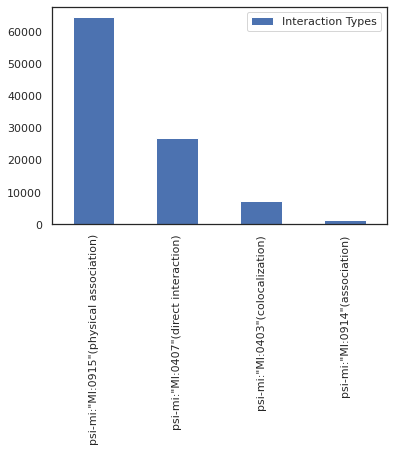

In [3]:
biogridp = biogrid[(biogrid['Interaction Types']=='MI:0915(physical association)')]
biogrida = biogrid[(biogrid['Interaction Types']=='MI:0914(association)')]
# biogridd = biogrid[(biogrid['Interaction Types']=='MI:0407(direct interaction)')]
biogrido = biogrid[(biogrid['Interaction Types']!='MI:0915(physical association)') & (biogrid['Interaction Types']!='MI:0914(association)')]
biogrid = pd.concat([biogrido,biogridp,biogrida]).drop_duplicates('Pairs')

sns.set(style='white')
pd.DataFrame(biogrid['Interaction Types'].value_counts()).plot.bar()

#### DIP

In [4]:
dip_dfs = []
for i in glob('../../ref/dip/*.txt.gz'):
    try:
        dip = pd.read_csv(i, sep='\t').reset_index()
        dip = dip.drop(['Processing Status','Unnamed: 16'], axis=1)
        dip.columns = list(dip.columns[1:16]) + ['Processing Status']
        dip_dfs.append(dip)
    except Exception:
        print(i)
        pass
dip = pd.concat(dip_dfs)
dip = dip[(dip['ID interactor A'].str.contains('uniprotkb:')) & (dip['ID interactor B'].str.contains('uniprotkb:'))].copy()
dip['ProteinA'] = dip['ID interactor A'].str.split('|')
dip['ProteinB'] = dip['ID interactor B'].str.split('|')
dip = dip.explode('ProteinA')
dip = dip[(dip['ProteinA'].str.contains('uniprotkb:'))].copy()
dip = dip.explode('ProteinB')
dip = dip[(dip['ProteinB'].str.contains('uniprotkb:'))].copy()
dip['ProteinA'] = dip['ProteinA'].str.replace('uniprotkb:','')
dip['ProteinB'] = dip['ProteinB'].str.replace('uniprotkb:','')

dip['DIP'] = dip[['ID interactor A','ID interactor B']].values.tolist()
dip['DIP'] = dip.DIP.apply(lambda x: '_'.join(sorted(x)))
dip['Pairs'] = dip[['ProteinA','ProteinB']].values.tolist()
dip['Pairs'] = dip.Pairs.apply(lambda x: '_'.join(sorted(x)))

dip['Taxid interactor A'] = dip['Taxid interactor A'].str.replace('taxid:','').str.split('(').apply(lambda x: x[0])
dip['Taxid interactor A'] = dip['Taxid interactor A'].astype(int)
dip['Taxid interactor B'] = dip['Taxid interactor B'].str.replace('taxid:','').str.split('(').apply(lambda x: x[0])
dip['Taxid interactor B'] = dip['Taxid interactor B'].astype(int)
dip['Taxsum'] = dip['Taxid interactor A'] + dip['Taxid interactor B']
dip[['DIP','Pairs','Taxsum']].to_pickle('dip.pkl.gz')

<AxesSubplot:>

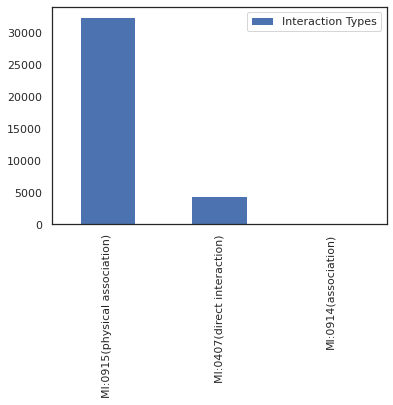

In [5]:
dip['Interaction Types'] = dip['Interaction type(s)'].str.split('|')
dip = dip.explode('Interaction Types').drop_duplicates()
dipp = dip[(dip['Interaction Types'].str.contains('MI:0915'))]
dipa = dip[(dip['Interaction Types'].str.contains('MI:0914'))]
dipd = dip[(dip['Interaction Types'].str.contains('MI:0407'))]
dipo = dip[(~dip['Interaction Types'].str.contains('MI:0915')) & (~dip['Interaction Types'].str.contains('MI:0914') & (dip['Interaction Types'].str.contains('MI:0407')))]
dip = pd.concat([dipo,dipd,dipp,dipa]).drop_duplicates('Pairs')

sns.set(style='white')
pd.DataFrame(dip['Interaction Types'].value_counts()).plot.bar()

#### IntAct

In [6]:
intact = pd.read_csv('../../ref/intact/intact.txt.gz', sep='\t')
intact = intact[(intact['#ID(s) interactor A'].str.contains('uniprotkb:')) & (intact['ID(s) interactor B'].str.contains('uniprotkb:'))]
intact['ProteinA'] = intact['#ID(s) interactor A'].str.replace('uniprotkb:','')
intact['ProteinB'] = intact['ID(s) interactor B'].str.replace('uniprotkb:','')

intact['IntAct'] = intact[['#ID(s) interactor A','ID(s) interactor B']].values.tolist()
intact['IntAct'] = intact.IntAct.apply(lambda x: '_'.join(sorted(x)))
intact['Pairs'] = intact[['ProteinA','ProteinB']].values.tolist()
intact['Pairs'] = intact.Pairs.apply(lambda x: '_'.join(sorted(x)))

intact['Taxid interactor A'] = intact['Taxid interactor A'].str.replace('taxid:','').str.split('(').apply(lambda x: x[0])
intact['Taxid interactor A'] = intact['Taxid interactor A'].astype(int)
intact['Taxid interactor B'] = intact['Taxid interactor B'].str.replace('taxid:','').str.split('(').apply(lambda x: x[0])
intact['Taxid interactor B'] = intact['Taxid interactor B'].astype(int)
intact['Taxsum'] = intact['Taxid interactor A'] + intact['Taxid interactor B']
intact[['IntAct','Pairs','Taxsum']].to_pickle('intact.pkl.gz')

<AxesSubplot:>

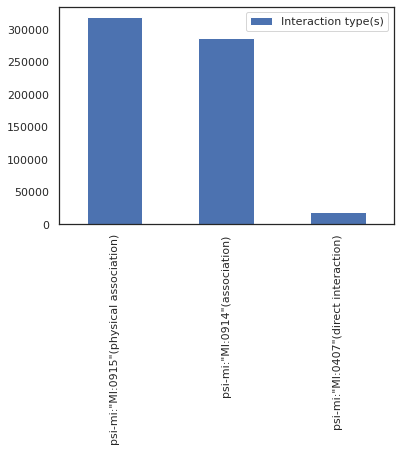

In [9]:
intactp = intact[(intact['Interaction type(s)'].str.contains('MI:0915'))]
intacta = intact[(intact['Interaction type(s)'].str.contains('MI:0914'))]
intactd = intact[(intact['Interaction type(s)'].str.contains('MI:0407'))]
intacto = intact[(~intact['Interaction type(s)'].str.contains('MI:0915')) & (~intact['Interaction type(s)'].str.contains('MI:0914') & (intact['Interaction type(s)'].str.contains('MI:0407')))]
intact = pd.concat([intacto,intactd,intactp,intacta]).drop_duplicates('Pairs')

sns.set(style='white')
pd.DataFrame(intact['Interaction type(s)'].value_counts()).plot.bar()

#### mentha

In [10]:
mentha = pd.read_csv('../../ref/mentha/2021-12-20_MITAB-2.5.zip', sep='\t', header=None)
mentha = mentha[(mentha[0].str.contains('uniprotkb:')) & (mentha[1].str.contains('uniprotkb:'))]
mentha['ProteinA'] = mentha[0].str.replace('uniprotkb:','')
mentha['ProteinB'] = mentha[1].str.replace('uniprotkb:','')

mentha['mentha'] = mentha[[0,1]].values.tolist()
mentha['mentha'] = mentha.mentha.apply(lambda x: '_'.join(sorted(x)))
mentha['Pairs'] = mentha[['ProteinA','ProteinB']].values.tolist()
mentha['Pairs'] = mentha.Pairs.apply(lambda x: '_'.join(sorted(x)))

mentha[9] = mentha[9].str.replace('taxid:','').str.split('(').apply(lambda x: x[0])
mentha[9] = mentha[9].astype(int)
mentha[10] = mentha[10].str.replace('taxid:','').str.split('(').apply(lambda x: x[0])
mentha[10] = mentha[10].astype(int)
mentha['Taxsum'] = mentha[9] + mentha[10]
mentha[['mentha','Pairs','Taxsum']].to_pickle('mentha.pkl.gz')

<AxesSubplot:>

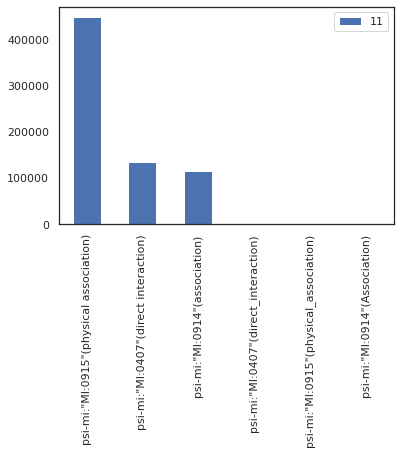

In [13]:
menthap = mentha[(mentha[11].str.contains('MI:0915'))]
menthaa = mentha[(mentha[11].str.contains('MI:0914'))]
menthad = mentha[(mentha[11].str.contains('MI:0407'))]
menthao = mentha[(~mentha[11].str.contains('MI:0915')) & (~mentha[11].str.contains('MI:0914') & (mentha[11].str.contains('MI:0407')))]
mentha = pd.concat([menthao,menthad,menthap,menthaa]).drop_duplicates('Pairs')

sns.set(style='white')
pd.DataFrame(mentha[11].value_counts()).plot.bar()

#### MINT

In [14]:
mint = pd.read_csv('../../ref/mint/mint.txt.gz', sep='\t', header=None)
mint = mint[(mint[0].str.contains('uniprotkb:')) & (mint[1].str.contains('uniprotkb:'))]
mint['ProteinA'] = mint[0].str.replace('uniprotkb:','')
mint['ProteinB'] = mint[1].str.replace('uniprotkb:','')

mint['MINT'] = mint[[0,1]].values.tolist()
mint['MINT'] = mint.MINT.apply(lambda x: '_'.join(sorted(x)))
mint['Pairs'] = mint[['ProteinA','ProteinB']].values.tolist()
mint['Pairs'] = mint.Pairs.apply(lambda x: '_'.join(sorted(x)))

mint[9] = mint[9].str.replace('taxid:','').str.split('(').apply(lambda x: x[0])
mint[9] = mint[9].astype(int)
mint[10] = mint[10].str.replace('taxid:','').str.split('(').apply(lambda x: x[0])
mint = mint[mint[10].apply(lambda x: x.isdigit())]
mint[10] = mint[10].astype(int)
mint['Taxsum'] = mint[9] + mint[10]
mint[['MINT','Pairs','Taxsum']].to_pickle('mint.pkl.gz')

<AxesSubplot:>

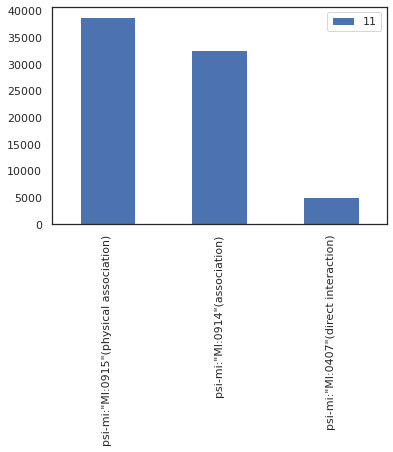

In [15]:
mintp = mint[(mint[11].str.contains('MI:0915'))]
minta = mint[(mint[11].str.contains('MI:0914'))]
mintd = mint[(mint[11].str.contains('MI:0407'))]
minto = mint[(~mint[11].str.contains('MI:0915')) & (~mint[11].str.contains('MI:0914') & (mint[11].str.contains('MI:0407')))]
mint = pd.concat([minto,mintd,mintp,minta]).drop_duplicates('Pairs')

sns.set(style='white')
pd.DataFrame(mint[11].value_counts()).plot.bar()

#### signor Jan2022 release

In [2]:
signor = pd.read_csv('../../ref/signor/Jan2022_release.txt.gz', sep='\t')
signor = signor[(signor.DATABASEA=='UNIPROT') & (signor.DATABASEB=='UNIPROT')].copy()
signor['Pairs'] = signor[['IDA','IDB']].values.tolist()
signor['Pairs'] = signor.Pairs.apply(lambda x: '_'.join(sorted(x)))
signor['signor'] = signor.Pairs
signor['Taxsum'] = signor.TAX_ID
signor[['signor','Pairs','Taxsum']].to_pickle('signor.pkl.gz')

#### BioPlex 3.0

In [4]:
df_int = pd.read_pickle('bioplex_interactions_aaindex1.pkl.gz')
df_int = df_int[df_int['Interaction']==1]
df_int['Pairs'] = df_int[['UniprotA','UniprotB']].values.tolist()
df_int['Pairs'] = df_int.Pairs.apply(lambda x: '_'.join(sorted([x[0], x[1]])))
df_int = df_int.drop_duplicates('Pairs')
df_int['BioPlex'] = df_int.Pairs
df_int['Taxsum'] = 9606
df_int[['BioPlex','Pairs','Taxsum']].to_pickle('bioplex.pkl.gz')

#### STRING

```console
cd ../../ref/string/
zcat protein.aliases.v11.5.txt.gz | grep BLAST_UniProt_AC | gzip > protein.aliases.UniProt_AC.v11.5.txt.gz
```

In [8]:
from pandarallel import pandarallel
pandarallel.initialize()

string = pd.read_csv('../../ref/string/protein.physical.links.full.exp.v11.5.txt.gz', sep='\s+')
aliases = pd.read_csv('../../ref/string/protein.aliases.UniProt_AC.v11.5.txt.gz', sep='\t', header=None)
aliases.columns = ['#string_protein_id','alias','source']
string = pd.merge(pd.merge(string, aliases.rename(columns={'#string_protein_id':'protein1'}), on='protein1'),\
                  aliases.rename(columns={'#string_protein_id':'protein2'}), on='protein2')

string['STRING'] = string[['protein1','protein2']].values.tolist()
string['STRING'] = string.STRING.parallel_apply(lambda x: '_'.join(sorted(x)))
string['Pairs'] = string[['alias_x','alias_y']].values.tolist()
string['Pairs'] = string.Pairs.parallel_apply(lambda x: '_'.join(sorted(x)))

string[9] = string.protein1.str.split('\.').parallel_apply(lambda x: x[0])
string[9] = string[9].astype(int)
string[10] = string.protein2.str.split('\.').parallel_apply(lambda x: x[0])
string[10] = string[10].astype(int)
string['Taxsum'] = string[9] + string[10]
string[['STRING','Pairs','Taxsum']].to_pickle('string.pkl.gz')

In [2]:
biogrid = pd.read_pickle('biogrid.pkl.gz')
dip = pd.read_pickle('dip.pkl.gz')
intact = pd.read_pickle('intact.pkl.gz')
mentha = pd.read_pickle('mentha.pkl.gz')
mint = pd.read_pickle('mint.pkl.gz')
signor = pd.read_pickle('signor.pkl.gz')
bioplex = pd.read_pickle('bioplex.pkl.gz')
string = pd.read_pickle('string.pkl.gz')

d = pd.merge(biogrid, dip, how='outer', on='Pairs').drop_duplicates(['BIOGRID','DIP'])
d = pd.merge(d, intact, how='outer', on='Pairs').drop_duplicates(['BIOGRID','DIP','IntAct'])
d = pd.merge(d, mentha, how='outer', on='Pairs').drop_duplicates(['BIOGRID','DIP','IntAct','mentha'])
d = pd.merge(d, mint, how='outer', on='Pairs').drop_duplicates(['BIOGRID','DIP','IntAct','mentha','MINT'])
d = pd.merge(d, signor, how='outer', on='Pairs').drop_duplicates(['BIOGRID','DIP','IntAct','mentha','MINT','signor'])
d = pd.merge(d, bioplex, how='outer', on='Pairs').drop_duplicates(['BIOGRID','DIP','IntAct','mentha','MINT','signor','BioPlex'])
d = pd.merge(d, string, how='outer', on='Pairs').drop_duplicates(['BIOGRID','DIP','IntAct','mentha','MINT','signor','BioPlex','STRING'])
d['BIOGRID 4.4.204'] = d.BIOGRID.notna()
d['DIP 20170205'] = d.DIP.notna()
d['IntAct 2021-10-13'] = d.IntAct.notna()
d['mentha 2021-12-20'] = d.mentha.notna()
d['MINT 2021-12-19'] = d.MINT.notna()
d['signor 2022-01-03'] = d.signor.notna()
d['BioPlex 3.0'] = d.BioPlex.notna()
d['STRING 11.5'] = d.STRING.notna()

d.to_pickle('db.pkl.gz')

#### Upset plot

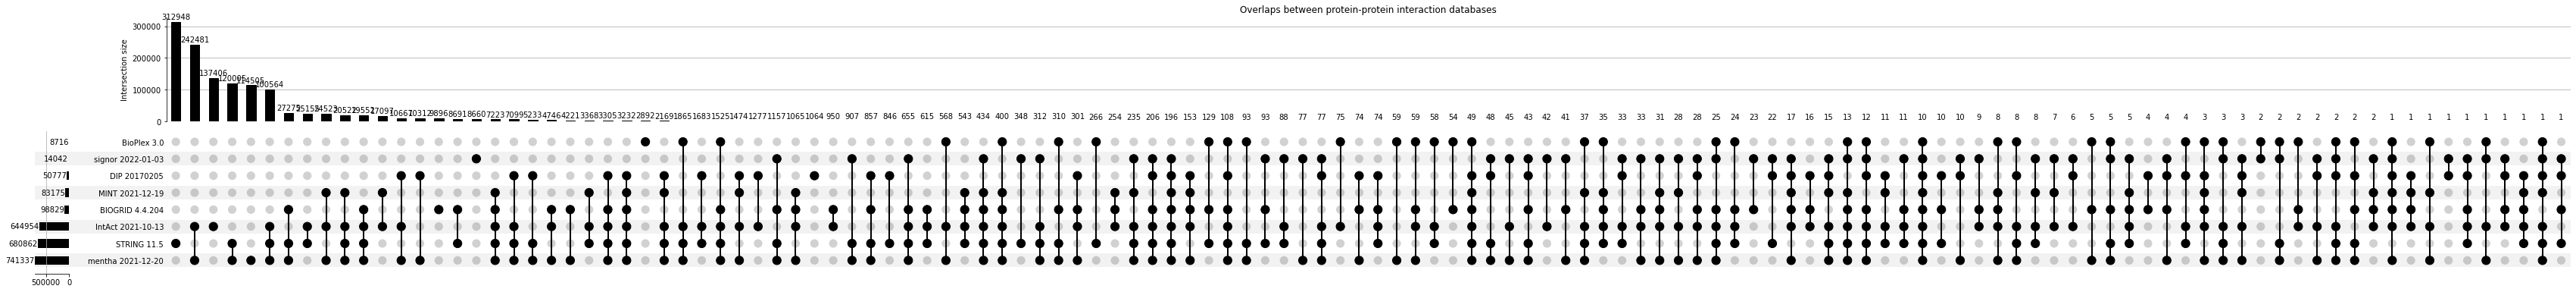

In [2]:
d = pd.read_pickle('db.pkl.gz')
strt = d[(d['BIOGRID 4.4.204']==False) & (d['DIP 20170205']==False) & (d['IntAct 2021-10-13']==False) & (d['mentha 2021-12-20']==False) & (d['MINT 2021-12-19']==False) & (d['signor 2022-01-03']==False) & (d['BioPlex 3.0']==False) & (d['STRING 11.5']==True)]
strf = pd.concat([d,strt]).drop_duplicates(keep=False)
strid = pd.concat([strf,strt])
strallid = set(pd.concat([strf,strt]).STRING.sort_values().unique()[0:-1])
strdupid = set(strid[strid.duplicated('STRING')].STRING.unique()[1:])
strincid = pd.DataFrame(strallid - strdupid)
strincid.columns = ['STRING']
strt = pd.merge(strincid,strt,on='STRING')

col = ['Pairs','BIOGRID 4.4.204','DIP 20170205','IntAct 2021-10-13','mentha 2021-12-20','MINT 2021-12-19','signor 2022-01-03','BioPlex 3.0','STRING 11.5']
d = pd.concat([strf[col],strt[col]]).drop_duplicates()
d = d.set_index(['BIOGRID 4.4.204','DIP 20170205','IntAct 2021-10-13','mentha 2021-12-20','MINT 2021-12-19','signor 2022-01-03','BioPlex 3.0','STRING 11.5'])

# sns.set(style='white')
upset = UpSet(d, subset_size='count', sort_by='cardinality', show_counts=True)
upset.plot()
plt.title("Overlaps between protein-protein interaction databases")
# plt.savefig('../../fig/upset_ppi.pdf')

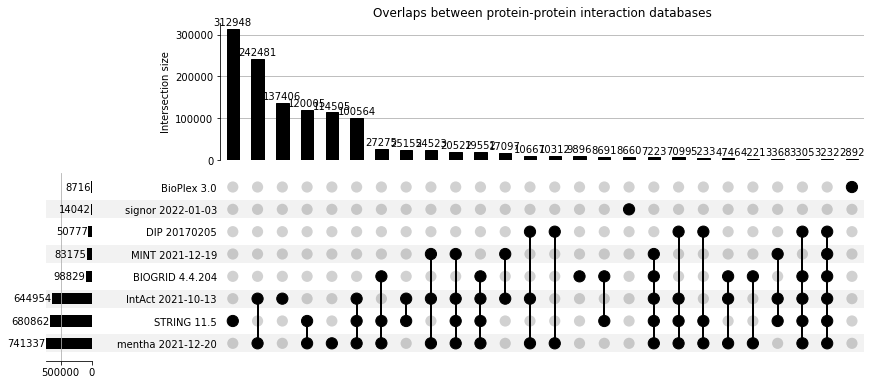

In [3]:
# sns.set(style='white')
upset = UpSet(d, subset_size='count', sort_by='cardinality', min_subset_size=2500, show_counts=True)
upset.plot()
plt.title("Overlaps between protein-protein interaction databases")
plt.savefig('../../fig/upset_min_subset_size_ppi.pdf')